# Model v18_attention

Path images, roughness metric = 1 second ahead, k-means 2, data split within sessions, images with attention region.

## Set-up

In [1]:
!pip install wandb

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 54.5MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [5]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-4')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

#### Load data

In [5]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'attention_region', 'v18')
image_path = '/gdrive/My Drive/Labeling/Segmentation/Predictions/AttentionRegion/0'
label_path = '/gdrive/My Drive/Labeling/LabelsCSV'

In [6]:
df = pd.read_csv(os.path.join(label_path, 'attention_region', 'labels_path_validated_mask_split_metric_2.csv'))
df = df.filter(items=['image_mask', 'group_2', 'dataset'])
print(len(os.listdir(image_path)), len(df))

# Categorical data
df['group_2'] = df['group_2'].astype(int).astype(str)

# Create is_valid column
df['is_valid'] = df['dataset'] == 'valid'

# Training set, filter out dataset column
train = df[df['dataset'] == 'train'].filter(items=['image_mask', 'group_2', 'is_valid'])

# Validation set, filter out dataset column
valid = df[df['dataset'] == 'valid'].filter(items=['image_mask', 'group_2', 'is_valid'])

5382 5375


#### Balance classes

In [7]:
# Training set
group_0 = train[train['group_2'] == '0']
group_1 = train[train['group_2'] == '1']

print(len(group_0))
print(len(group_1))

2838
751


Training and validation set have the same balanced ratio of 1.10.

In [8]:
group_0 = group_0[:827]

train_balanced = group_0.append(group_1)

print(len(train_balanced))
print(len(train_balanced[train_balanced['group_2'] == '0']))
print(len(train_balanced[train_balanced['group_2'] == '1']))

1578
827
751


In [9]:
# Validation set
group_0_v = valid[valid['group_2'] == '0']
group_1_v = valid[valid['group_2'] == '1']

print(len(group_0_v))
print(len(group_1_v))

676
224


In [10]:
group_0_v = group_0_v[:246]

valid_balanced = group_0_v.append(group_1_v)
print(len(valid_balanced))
print(len(valid_balanced[valid_balanced['group_2'] == '0']))
print(len(valid_balanced[valid_balanced['group_2'] == '1']))

470
246
224


In [11]:
df_balanced = train_balanced.append(valid_balanced)
print(len(df_balanced))
print(len(df_balanced[df_balanced['is_valid'] == False]))
print(len(df_balanced[df_balanced['is_valid'] == True]))

2048
1578
470


In [12]:
df_balanced.head()

,image_mask,group_2,is_valid
0,969905035s184ms.png,0,False
1,970588340s260ms.png,0,False
2,969905551s166ms.png,0,False
3,970588244s264ms.png,0,False
4,970328566s709ms.png,0,False


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [13]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [14]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [15]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

1578 1578
470 470


In [16]:
print(data.classes)

['0', '1']


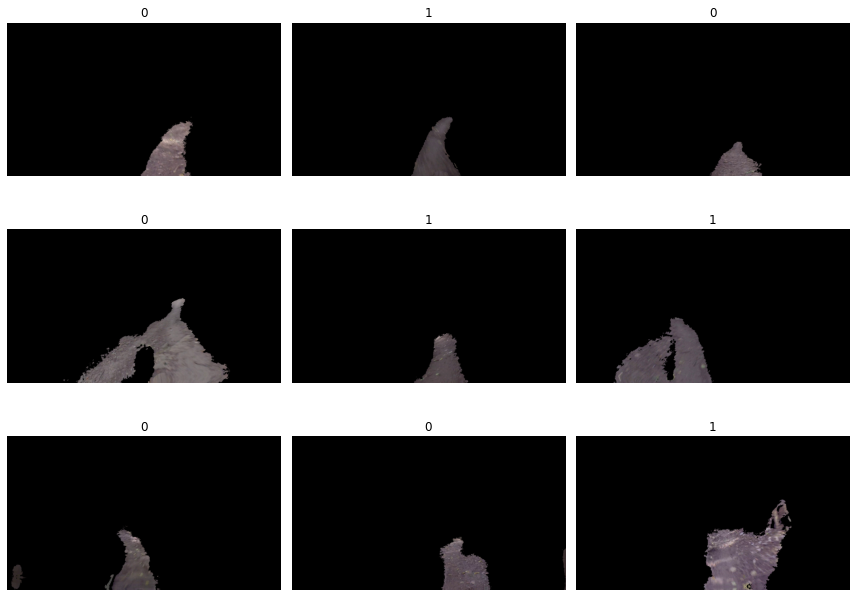

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [19]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)
# learn = cnn_learner(data, arch, metrics=[accuracy])

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


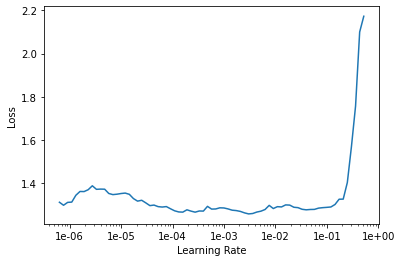

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.373784,0.997442,0.523404,09:41
1,1.111144,0.782560,0.574468,07:29
2,0.969082,0.948742,0.514894,07:25
3,0.880506,0.846877,0.546808,07:20
4,0.812769,0.747782,0.559574,07:33


Better model found at epoch 0 with valid_loss value: 0.9974424839019775.
Better model found at epoch 1 with valid_loss value: 0.7825595140457153.
Better model found at epoch 4 with valid_loss value: 0.7477817535400391.
Loaded best saved model from /content/wandb/run-20210107_030122-1j99rogy/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v18-attention-stage-1'))

In [ ]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.708466,0.922673,0.538298,07:37
1,0.722053,0.877789,0.538298,07:35


Better model found at epoch 0 with valid_loss value: 0.9226725101470947.
Better model found at epoch 1 with valid_loss value: 0.8777886629104614.
Loaded best saved model from /content/wandb/run-20210107_030122-1j99rogy/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v18-attention-stage-1'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

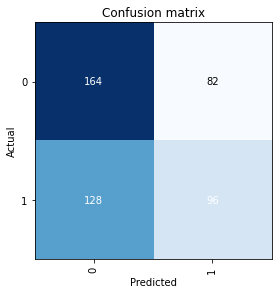

In [ ]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
learn.load(os.path.join(folder_path, 'v18-attention-stage-1'))

In [20]:
bs = 16    # uncomment this line if you run out of memory
learn.data.batch_size = 16

In [21]:
learn.data.batch_size

16

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


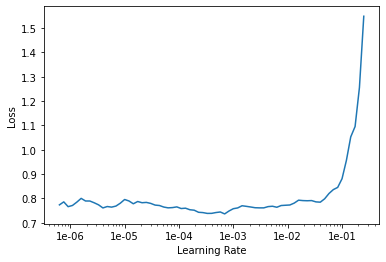

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.754127,0.810906,0.587234,06:54
1,0.750492,0.733786,0.565957,06:30
2,0.683176,0.955234,0.561702,06:26
3,0.682823,0.707660,0.597872,06:26
4,0.627930,0.707136,0.608511,06:24


Better model found at epoch 0 with valid_loss value: 0.8109064102172852.
Better model found at epoch 1 with valid_loss value: 0.7337856292724609.
Better model found at epoch 3 with valid_loss value: 0.7076596021652222.
Better model found at epoch 4 with valid_loss value: 0.707135796546936.
Loaded best saved model from /content/wandb/run-20210107_145625-gbbltyj4/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v18-attention-stage-2'))

In [ ]:
learn.fit_one_cycle(2, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.674298,0.785802,0.600000,06:28
1,0.629962,0.723523,0.608511,06:26


Better model found at epoch 0 with valid_loss value: 0.7858017086982727.
Better model found at epoch 1 with valid_loss value: 0.7235230207443237.
Loaded best saved model from /content/wandb/run-20210107_145625-gbbltyj4/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v18-attention-stage-2'))

In [ ]:
learn.freeze()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

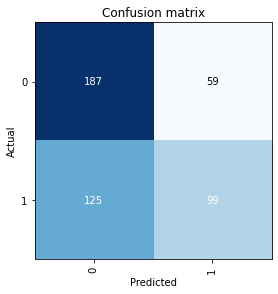

In [ ]:
interp.plot_confusion_matrix()

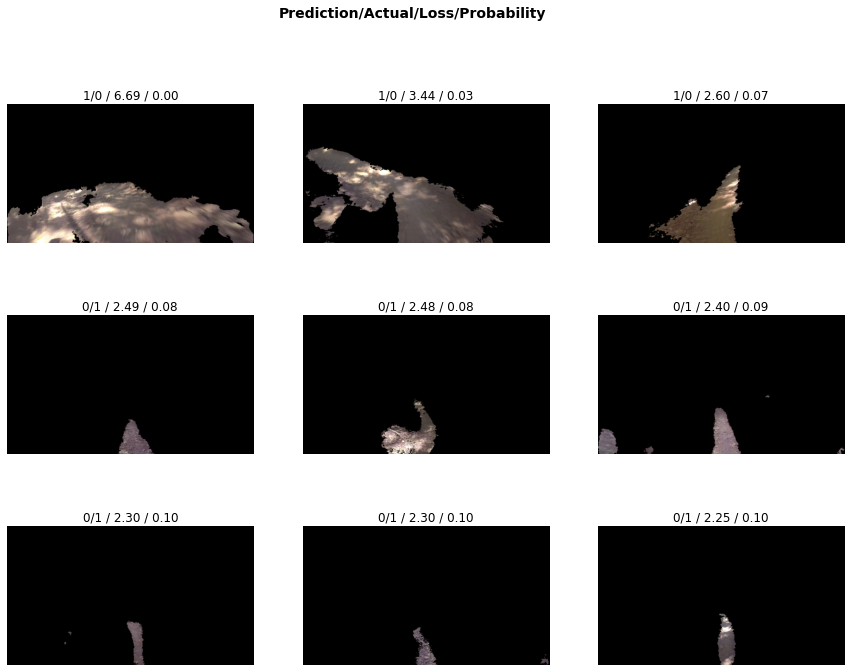

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

#### Fine-tune using the same learning rate as v18_original

In [ ]:
learn.load(os.path.join(folder_path, 'v18-attention-stage-1'))

In [44]:
learn.data.batch_size = 16

In [45]:
learn.data.batch_size

16

In [46]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.720527,0.724003,0.578723,07:13
1,0.703068,0.708998,0.565957,06:07
2,0.698317,0.714688,0.570213,06:03
3,0.694410,0.711127,0.582979,05:59
4,0.666268,0.708429,0.580851,05:53


Better model found at epoch 0 with valid_loss value: 0.7240028381347656.
Better model found at epoch 1 with valid_loss value: 0.708998441696167.
Better model found at epoch 4 with valid_loss value: 0.7084290385246277.
Loaded best saved model from /content/wandb/run-20210108_003619-3g8adkxt/files/bestmodel.pth


In [52]:
learn.save(os.path.join(folder_path, 'v18-attention-stage-2-2'))

In [53]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.677805,0.718464,0.578723,06:00
1,0.680725,0.715212,0.591489,05:53


Better model found at epoch 0 with valid_loss value: 0.7184644937515259.
Better model found at epoch 1 with valid_loss value: 0.7152122855186462.
Loaded best saved model from /content/wandb/run-20210108_003619-3g8adkxt/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v18-attention-stage-2-2'))

In [23]:
learn.freeze()

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

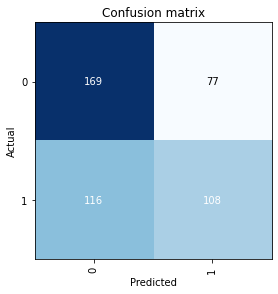

In [25]:
interp.plot_confusion_matrix()